![arangodb](https://github.com/arangodb/interactive_tutorials/blob/master/notebooks/img/ArangoDB_logo.png?raw=1)

# ArangoSearch Part II: Advanced Graph Traversal 


<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/ArangoSearchOnGraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a follow-up to the [first ArangoSearch notebook](https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/ArangoSearch.ipynb). We will be diving into more advanced and complicated queries - which highlight the power of combining ArangoSearch's information retrieval and search capabilities with the AQL's Graph traversal features.

We'll be using the same dataset as before: The IMDb dataset, which contains information about movies, their actors and directors, as well as users who have viewed and rated them.

You'll learn how to take the results from an ArangoSearch query and use them as the basis for a graph traversal. We'll also be taking a look at aggregations that you can use to create higher level insights around nodes in your graph, by calculating things such as average movie ratings and actors' star power.

By the end of this tutorial you should be more familiar with how you can use these two tools together to compose your own sophisticated queries!

# Setup

Before getting started with ArangoDB and ArangoSearch we need to prepare our environment and create a database on ArangoDB's managed Service Oasis.

In [1]:
%%capture
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!rsync -av interactive_tutorials/ ./ --exclude=.git
!chmod -R 755 ./tools
!git clone -b imdb_complete --single-branch https://github.com/arangodb/interactive_tutorials.git imdb_complete
!rsync -av imdb_complete/data/imdb_dump/ ./imdb_dump/
!pip3 install pyarango
!pip3 install "python-arango>=5.0"

In [2]:
import json
import requests
import sys
import oasis
import time
import textwrap

from pyArango.connection import *
from arango import ArangoClient

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Create the database
If you already have an Oasis account, and would like to keep your database at the end of this tutorial for later reference or experimentation, you can create a test database. In an existing or new deployment, you can select the `Examples` tab, and then click `Create test database`. This will then provide with you with credentials that you can enter in the cell below! If you don't have an Oasis account yet, but would like to get started, you can [sign up here!](https://cloud.arangodb.com/home)



In [ ]:
login = {
    "hostname": "https://foo.cloud",
    "port": "8529",
    "username": "foo",
    "password": "bar",
    "dbName": "myTutorialDatabase"
}

If you don't have an Oasis account, or want to create a temporary database, please run the following:

In [3]:
# Retrieve tmp credentials from ArangoDB Tutorial Service
login = oasis.getTempCredentials(tutorialName="ArangoSearchOnGraphs", credentialProvider="https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB")

Requesting new temp credentials.
Temp database ready to use.


Once you have your login credentials, we can connect to the database:

In [4]:
# Connect to the database
# Please note that we use the python-arango driver as it has better support for ArangoSearch 
database = oasis.connect_python_arango(login)

In [5]:
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

https://tutorials.arangodb.cloud:8529
Username: TUTd7z2cubo1qd08vww380b9tv
Password: TUTsjavjwyvoqhtexpsa9vjm
Database: TUTjsbdgafntkv7u6o1ly78a


Feel free to use the above URL to checkout the ArangoDB WebUI!

# Import IMDB Example Dataset

Next we will import the IMDb dataset. 
**N.B.** the included arangorestore will only work on Linux or Windows systems, if you want to run this notebook on a different OS please consider using the appropriate arangorestore from the [Download area](https://www.arangodb.com/download-major/).

## Linux

In [6]:
! ./tools/arangorestore -c none --server.endpoint http+ssl://{login["hostname"]}:{login["port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --default-replication-factor 3  --input-directory "imdb_dump"

2021-06-15T13:50:05Z [146] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://tutorials.arangodb.cloud:8529'
2021-06-15T13:50:05Z [146] INFO [3b6a4] {restore} no properties object
2021-06-15T13:50:05Z [146] INFO [9b414] {restore} # Re-creating document collection 'imdb_vertices'...
2021-06-15T13:50:06Z [146] INFO [9b414] {restore} # Re-creating document collection 'Users'...
2021-06-15T13:50:06Z [146] INFO [9b414] {restore} # Re-creating edge collection 'imdb_edges'...
2021-06-15T13:50:07Z [146] INFO [9b414] {restore} # Re-creating edge collection 'Ratings'...
2021-06-15T13:50:08Z [146] INFO [94913] {restore} # Loading data into document collection 'Users', data size: 15255 byte(s)
2021-06-15T13:50:08Z [146] INFO [94913] {restore} # Loading data into document collection 'imdb_vertices', data size: 4752344 byte(s)
2021-06-15T13:50:08Z [146] INFO [6d69f] {restore} # Dispatched 4 job(s), using 2 worker(s)
2021-06-15T13:50:08Z [146] INFO [6ae09] {restore} # Successfully restored docu

# Create A Search View

As discussed above, an ArangoSearch view contains references to documents stored in different collections. Thus, it is possible to perform complex federated searches, even over a complete graph including vertex and edge collections.

We'll create an ArangoSearch view and add a few field level [Analyzers](https://www.arangodb.com/docs/3.7/analyzers.html) so that we can do sophisticated full-text searches. These analyzers allow us to transform input search strings into sub-values that match the data in our graph!

In [7]:
# Create an ArangoSearch view.
database.create_arangosearch_view(
    name='v_imdb',
    properties={'cleanupIntervalStep': 0}
)

{'cleanup_interval_step': 0,
 'commit_interval_msec': 1000,
 'consolidation_interval_msec': 1000,
 'consolidation_policy': {'min_score': 0,
  'segments_bytes_floor': 2097152,
  'segments_bytes_max': 5368709120,
  'segments_max': 10,
  'segments_min': 1,
  'type': 'tier'},
 'global_id': 'c3749309835/',
 'id': '3749309835',
 'links': {},
 'name': 'v_imdb',
 'primary_sort': [],
 'primary_sort_compression': 'lz4',
 'stored_values': [],
 'type': 'arangosearch',
 'writebuffer_active': 0,
 'writebuffer_idle': 64,
 'writebuffer_max_size': 33554432}

Below we're specifying the links to the `imdb_vertices` collection and the Analyzers we want to select per field.

In [8]:
 link = { 
  "includeAllFields": True,
  "fields" : { 
      "title" : { "analyzers" : ["text_en"] },
      "description" : { "analyzers" : ["text_en"] }
      }
}


database.update_arangosearch_view(
    name='v_imdb',
    properties={'links': { 'imdb_vertices': link }}
)

{'cleanup_interval_step': 0,
 'commit_interval_msec': 1000,
 'consolidation_interval_msec': 1000,
 'consolidation_policy': {'min_score': 0,
  'segments_bytes_floor': 2097152,
  'segments_bytes_max': 5368709120,
  'segments_max': 10,
  'segments_min': 1,
  'type': 'tier'},
 'global_id': 'c3749309835/',
 'id': '3749309835',
 'links': {'imdb_vertices': {'analyzers': ['identity'],
   'fields': {'description': {'analyzers': ['text_en']},
    'title': {'analyzers': ['text_en']}},
   'include_all_fields': True,
   'store_values': 'none',
   'track_list_positions': False}},
 'name': 'v_imdb',
 'primary_sort': [],
 'primary_sort_compression': 'lz4',
 'stored_values': [],
 'type': 'arangosearch',
 'writebuffer_active': 0,
 'writebuffer_idle': 64,
 'writebuffer_max_size': 33554432}

ArangoSearch includes a set of built-in language-specific Analyzers for your convenience. [See here](https://www.arangodb.com/docs/stable/analyzers.html#built-in-analyzers) for the complete list.

We also provide the possibility to define custom analyzers, allowing you to apply splitting rules such as [character ngrams](https://www.arangodb.com/docs/stable/analyzers.html#ngram).

# Search on Graphs

## Searching for relevant directors

Suppose you're a movie producer who's shopping around within a few different subject areas. We can use ArangoSearch to figure out who we should be talking to!

Let's start with a few of the keywords that we think are relevant to movies that we'd want to produce and see if we can find potential directors in these areas:


In [9]:
cursor = database.aql.execute(
"""
FOR d IN v_imdb 
   SEARCH ANALYZER(d.description IN TOKENS('fantasy alien sci-fi galaxy', 'text_en'), 'text_en')
   LET score = BM25(d)
   SORT score DESC
   LIMIT 75 
   FOR vertex, edge, path IN 1..1 INBOUND d imdb_edges
     FILTER path.edges[0].$label == "DIRECTED"
     SORT score DESC
     RETURN DISTINCT {"director" : vertex.name } 
"""
)
# Iterate through the result cursor
for doc in cursor:
  print(doc)

{'director': 'Colin Strause'}
{'director': 'Greg Strause'}
{'director': 'Roland Emmerich'}
{'director': 'John Carpenter'}
{'director': 'Phil Tippett'}
{'director': 'Kazuhisa Takenôchi'}
{'director': 'Richard Linklater'}
{'director': 'Stanley Donen'}
{'director': 'David Twohy'}
{'director': 'Jae-young Kwak'}
{'director': 'Irvin S. Yeaworth Jr.'}
{'director': 'Karel Zeman'}
{'director': 'Chuck Russell'}
{'director': 'Jack Sholder'}
{'director': 'Paul McGuigan'}
{'director': 'Brian Henson'}
{'director': 'Kazuaki Kiriya'}
{'director': 'Michael Anderson'}
{'director': 'Peter Yates'}
{'director': 'Garth Jennings'}
{'director': 'Robert C. Cooper'}
{'director': 'Stewart Raffill'}
{'director': 'George Lucas'}
{'director': 'J.J. Abrams'}
{'director': 'P.J. Hogan'}
{'director': 'Rintaro'}
{'director': 'Rupert Harvey'}
{'director': 'Roger Vadim'}
{'director': 'Stephen Hopkins'}
{'director': 'Robert Redford'}
{'director': 'Griffin Dunne'}
{'director': 'Dwight H. Little'}
{'director': 'Michael Traeg

Here we're building on the results of our search query of movie descriptions by using a graph traversal. The `IN 1..1 INBOUND` specifies that we only want to traverse one vertex away from our current nodes. In this setting, traversals start from a movie and then look at all inbound edges with the label "DIRECTED," which in this graph means that the vertices on the other end are our directors!

## Searching for relevant actors


Now that we know which directors we might want to talk to, we can ask:

Who are the actors who've acted in more than one of these movies?


In [10]:
cursor = database.aql.execute(
"""
FOR d IN v_imdb 
  SEARCH ANALYZER(d.description IN TOKENS('fantasy alien sci-fi galaxy', 'text_en'), 'text_en')
  LET score = BM25(d)
  SORT score DESC
  LIMIT 75 
  FOR vertex, edge, path IN 1..1 INBOUND d imdb_edges
    FILTER path.edges[0].$label == "ACTS_IN"
    COLLECT actorName = vertex.name INTO titlesByActor
    LET actedIn = UNIQUE(titlesByActor[*].d.title)
    FILTER LENGTH(actedIn) > 1
    SORT LENGTH(actedIn) DESC
    RETURN {
      actor: actorName,
      actedIn
    }
"""
)
# Iterate through the result cursor
for doc in cursor:
  print(doc)

{'actor': 'John Malkovich', 'actedIn': ["The Hitchhiker's Guide to the Galaxy", 'Being John Malkovich']}
{'actor': 'Winona Ryder', 'actedIn': ['A Scanner Darkly', 'Star Trek']}
{'actor': 'Temuera Morrison', 'actedIn': ['Star Wars: Episode III: Revenge of the Sith', 'Star Wars: Episode II - Attack of the Clones']}
{'actor': 'Silas Carson', 'actedIn': ['Star Wars: Episode III: Revenge of the Sith', 'Star Wars: Episode II - Attack of the Clones']}
{'actor': 'Samuel L. Jackson', 'actedIn': ['Star Wars: Episode III: Revenge of the Sith', 'Star Wars: Episode II - Attack of the Clones']}
{'actor': 'Robin Williams', 'actedIn': ['Hook', 'One Hour Photo']}
{'actor': 'Robert Redford', 'actedIn': ['Lions for Lambs', 'The Natural']}
{'actor': 'Natalie Portman', 'actedIn': ['Star Wars: Episode III: Revenge of the Sith', 'Star Wars: Episode II - Attack of the Clones']}
{'actor': 'Kenny Baker', 'actedIn': ['Star Wars: Episode III: Revenge of the Sith', 'Star Wars: Episode II - Attack of the Clones']}


In the above query, we're starting to dive into more advanced queries. Here we're still doing a graph traversal with a max distance of 1, but we're also performing a grouping!

The `COLLECT` keyword allows us to perform a grouping to gather all of the movies connected to a unique actor name into a single group. Once we group the movies, we can use an [ArangoDB array expansion operator](https://www.arangodb.com/docs/stable/aql/advanced-array-operators.html) to gather the unique movie titles per actor.

If you want to learn more about grouping, please look at the documentation [here](https://www.arangodb.com/docs/stable/aql/examples-grouping.html).

## Searching for good actors

We might also want to approach actors who've acted in these movies, who have the highest "star power". Here we'll define star power as the average rating of all movies in which an actor has appeared. We can search for these actors as follows:

In [11]:
cursor = database.aql.execute(
    """
    FOR d in v_imdb
      SEARCH ANALYZER(d.description IN TOKENS('fantasy alien sci-fi galaxy', 'text_en'), 'text_en')
      LET score = BM25(d)
      SORT score DESC
      LIMIT 75
        FOR a, e, p IN 2..2 ANY d imdb_edges
          FILTER p.edges[0].$label == 'ACTS_IN'
          FILTER p.edges[1].$label == 'ACTS_IN'
          LET movieRating = AVG(
            FOR user, rating, path in 1..1 INBOUND p.vertices[2] Ratings
              RETURN rating.rating
          )
          COLLECT actorName = p.vertices[1].name
          AGGREGATE avgRating = AVG(movieRating)
          INTO actorRatings
          SORT avgRating DESC
          LIMIT 20
          RETURN { actorName, avgRating }
    """
)
for doc in cursor:
  print(doc)

{'actorName': 'Kirk Douglas', 'avgRating': 4.4}
{'actorName': 'Cliff Curtis', 'avgRating': 4.136363636363637}
{'actorName': 'Derek Luke', 'avgRating': 4.085714285714285}
{'actorName': 'Hugo Weaving', 'avgRating': 4.041958041958042}
{'actorName': 'Richard Briers', 'avgRating': 4.035714285714286}
{'actorName': 'Akira Terao', 'avgRating': 4}
{'actorName': 'Djimon Hounsou', 'avgRating': 3.95}
{'actorName': 'Caroline Goodall', 'avgRating': 3.941728606822946}
{'actorName': 'Kate Winslet', 'avgRating': 3.925091671031954}
{'actorName': 'Olin Howland', 'avgRating': 3.9152542372881354}
{'actorName': 'Dianne Wiest', 'avgRating': 3.7868852459016393}
{'actorName': 'Willie Garson', 'avgRating': 3.76878612716763}
{'actorName': 'James Cromwell', 'avgRating': 3.7627250331589956}
{'actorName': 'Kim Basinger', 'avgRating': 3.757163671685284}
{'actorName': 'Rex Harrison', 'avgRating': 3.7560975609756095}
{'actorName': 'Alan Rickman', 'avgRating': 3.7554417867146412}
{'actorName': 'Diana Kent', 'avgRating'

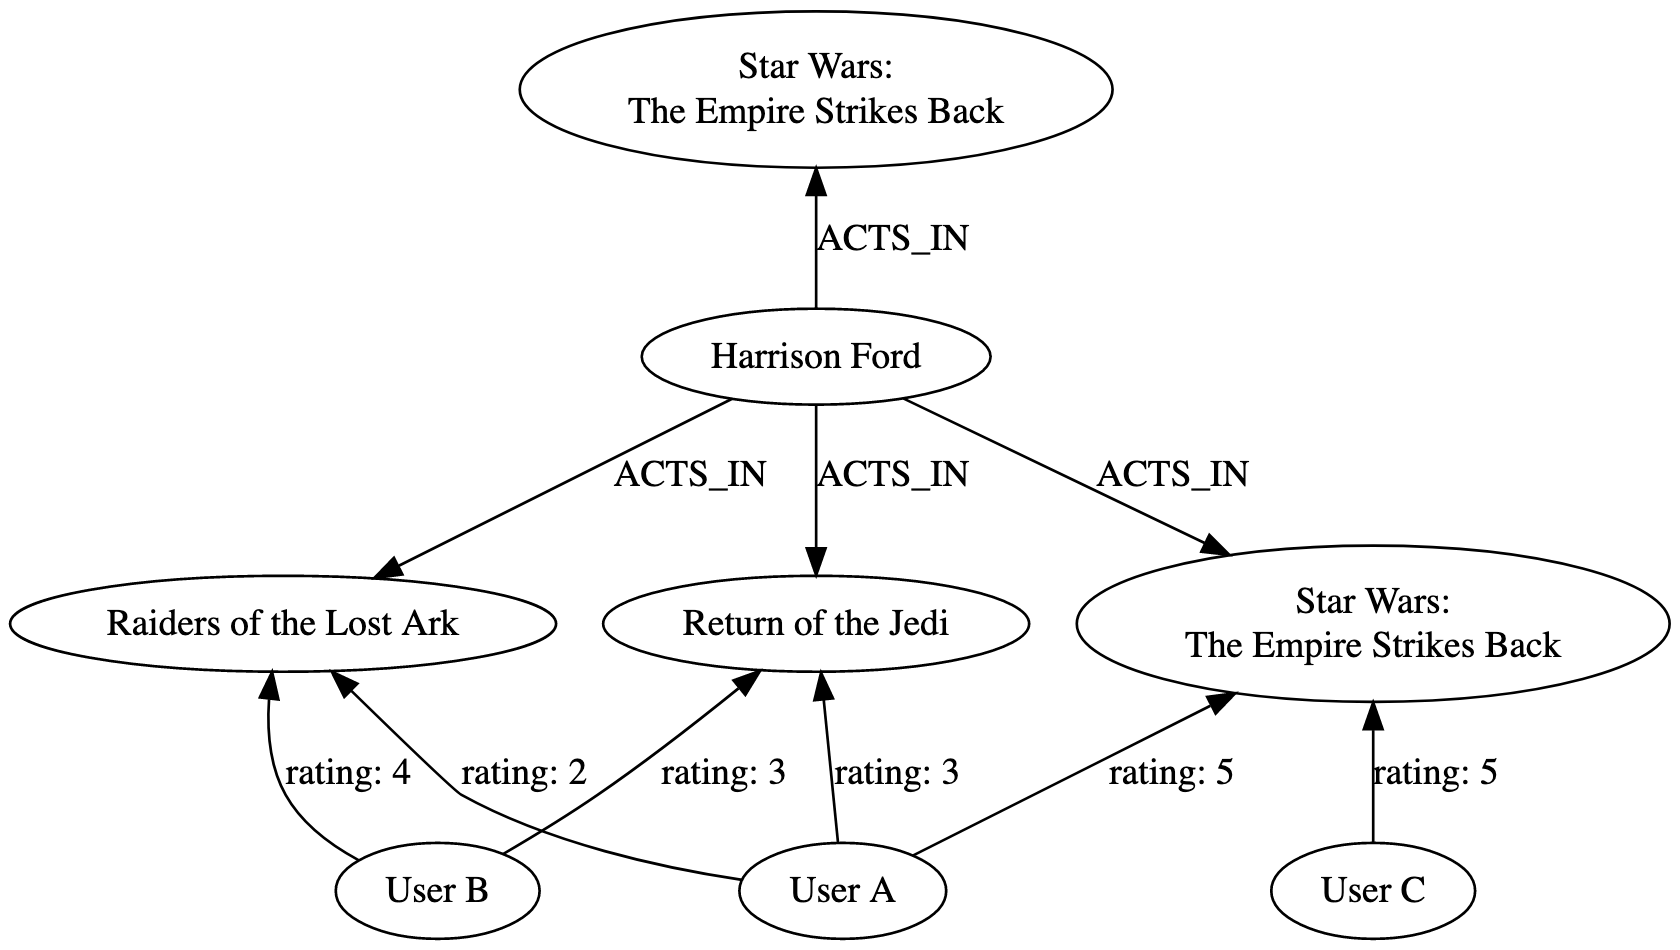


The above query lets us see that we can traverse through the graph to find paths that retrieve useful information further away than a single edge! In this case, the `2..2` in the graph traversal indicates that we only want paths that contain precisely two edges.  Furthermore, the `ANY` keyword indicates that in this case, we don't care about the directions of the edges, as we're able to restrict the paths by filtering based on the respective edge labels.

We're filtering both edges by the term `ACTS_IN` - which means that the second vertex will be an actor, and the third will be a movie that the actor has acted in. You might've also noticed that we have a nested query after this! The `movieRating` variable contains the average of all of the third vertex's ratings (the movie). We can then see this as the movie's rating.

Once we have this traversal, we can do another grouping, this time with an aggregation, which allows us to calculate the average rating of the movies that the actor has acted in (the "star power"), which we can use to sort.

Please [see here](https://www.arangodb.com/docs/stable/aql/examples-grouping.html#aggregation) if you want to learn more about aggregations in ArangoDB.

# Searching for good directors

Along the same lines as the previous search, we can also take a look at which of the relevant directors have the best results at the box office based on their ratings:

In [12]:
cursor = database.aql.execute(
    """
    FOR d in v_imdb
      SEARCH ANALYZER(d.description IN TOKENS('fantasy alien sci-fi galaxy', 'text_en'), 'text_en')
      LET score = BM25(d)
      SORT score DESC
      LIMIT 75
        FOR a, e, p IN 2..2 ANY d imdb_edges
          FILTER p.edges[0].$label == 'DIRECTED'
          FILTER p.edges[1].$label == 'DIRECTED'
          LET movieRating = AVG(
            FOR user, rating, path in 1..1 INBOUND p.vertices[2] Ratings
              RETURN rating.rating
          )
          COLLECT directorName = p.vertices[1].name
          AGGREGATE avgRating = AVG(movieRating)
          INTO directorRatings
          SORT avgRating DESC
          LIMIT 20
          RETURN { directorName, avgRating, movies: UNIQUE(directorRatings[*].p.vertices[2].title) }
    """
)
for doc in cursor:
  print(doc)

{'directorName': 'Steven Spielberg', 'avgRating': 3.958950456937533, 'movies': ["Schindler's List", 'Jurassic Park', 'Indiana Jones and the Last Crusade', 'Minority Report', 'The Color Purple', 'Always', 'Twilight Zone: The Movie', 'Munich', 'Indiana Jones and the Raiders of the Lost Ark', 'Indiana Jones and the Kingdom of the Crystal Skull', 'E.T.: The Extra-Terrestrial', 'Catch Me If You Can', 'Jaws', 'Indiana Jones and the Temple of Doom', 'A.I. Artificial Intelligence', 'War of the Worlds', 'The Sugarland Express', 'The Terminal', 'The Lost World: Jurassic Park', 'Empire of the Sun', 'The Adventures of Tintin: The Secret of the Unicorn', 'Close Encounters of the Third Kind', 'Saving Private Ryan', 'Amistad', '1941', 'Duel', 'Hook']}
{'directorName': 'Stanley Donen', 'avgRating': 3.849406991260924, 'movies': ['Two for the Road', "It's Always Fair Weather", "Singin' in the Rain", 'Charade', 'Bedazzled', 'Funny Face', 'Seven Brides for Seven Brothers', 'Saturn 3']}
{'directorName': 'P

##Searching for fruitful collaborations

We also might want to determine who we talk to based on how often people have worked together. For example, we can search for relevant directors and actors who have worked together often as follows:

In [13]:
cursor = database.aql.execute(
    """
    FOR d in v_imdb
      SEARCH ANALYZER(d.description IN TOKENS('fantasy alien sci-fi galaxy', 'text_en'), 'text_en')
      LET score = BM25(d)
      SORT score DESC
      LIMIT 75
        FOR a, e, p IN 3..3 ANY d imdb_edges
        FILTER p.edges[0].$label == 'DIRECTED'
        FILTER p.edges[1].$label == 'DIRECTED'
        FILTER p.edges[2].$label == 'ACTS_IN'
        COLLECT directorName = p.vertices[1].name,
                  actorName = a.name
        AGGREGATE numMovies = LENGTH(1)
        INTO directorsFavorites
        LET uniqueMovies = UNIQUE(directorsFavorites[*].p.vertices[2].title)
        SORT LENGTH(uniqueMovies) DESC
        LIMIT 20
        RETURN { directorName, actorName, numberOfMovies: LENGTH(uniqueMovies), movies: uniqueMovies }
    """
)
for doc in cursor:
  print(doc)

{'directorName': 'George Lucas', 'actorName': 'Anthony Daniels', 'numberOfMovies': 4, 'movies': ['Star Wars: Episode IV - A New Hope', 'Star Wars: Episode II - Attack of the Clones', 'Star Wars: Episode I - The Phantom Menace', 'Star Wars: Episode III: Revenge of the Sith']}
{'directorName': 'John Carpenter', 'actorName': 'Kurt Russell', 'numberOfMovies': 4, 'movies': ['The Thing', 'Escape from New York', 'Escape from L.A.', 'Big Trouble in Little China']}
{'directorName': 'George Lucas', 'actorName': 'Kenny Baker', 'numberOfMovies': 4, 'movies': ['Star Wars: Episode IV - A New Hope', 'Star Wars: Episode II - Attack of the Clones', 'Star Wars: Episode I - The Phantom Menace', 'Star Wars: Episode III: Revenge of the Sith']}
{'directorName': 'Richard Linklater', 'actorName': 'Ethan Hawke', 'numberOfMovies': 4, 'movies': ['Before Sunset', 'Before Sunrise', 'Fast Food Nation', 'Waking Life']}
{'directorName': 'Barry Levinson', 'actorName': 'Dustin Hoffman', 'numberOfMovies': 4, 'movies': [

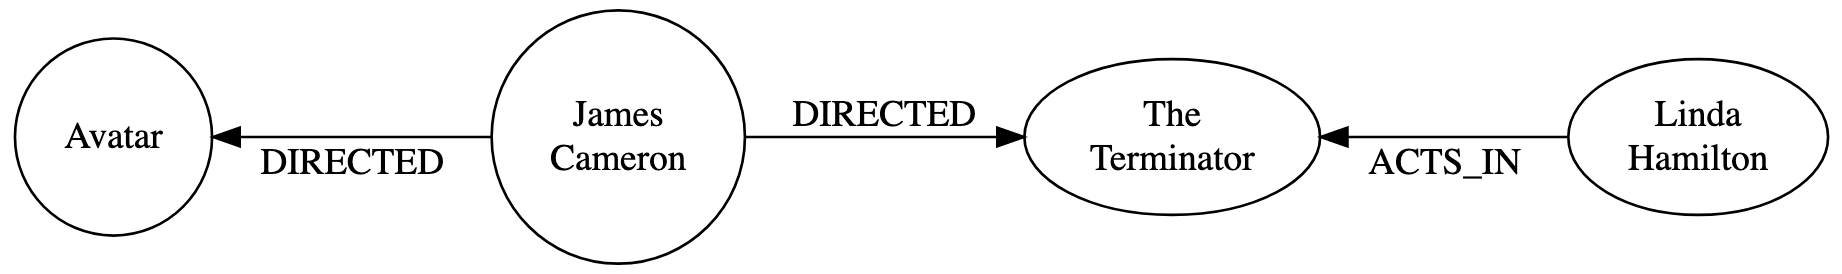

This query goes one hop further than the previous graph traversal! The `IN 3..3 ANY` in the graph traversal indicates that we only want paths that contain precisely three edges.

An example of a path that we traverse in this query is included above.


It may seem a little complicated at first, but we can break down the traversal as follows:

1. We start at vertices which are movies.

2. The 1st edge is restricted to directors by filtering on the edge label. So the second vertex in our path is the Director of the Movie.

3. The 2nd edge is again restricted by `DIRECTED` - which means that we end up at a movie that the Director has also directed (Note that this could be the same Movie that we started at).

4. The 3rd edge is restricted to actors, which means that we have a final vertex containing information about an associated actor.

Once we have this traversal, we can do another grouping and aggregation, which allows us to count the number of unique movies per actor/director combination, which we can use to sort by the highest number of relevant collaborations.

# Next Steps

This tutorial demonstrates the powerful queries that you can write when combining ArangoSearch's text search capabilities with the native graph traversals in ArangoDB. If you would like to continue learning more about ArangoDB, here are some next steps to get you started!

* [Get a 2 week free Trial with the ArangoDB Cloud](https://cloud.arangodb.com/home?utm_source=AQLJoin&utm_medium=Github&utm_campaign=ArangoDB%20University)
* [Download ArangoDB](https://www.arangodb.com/download-major/)
* [Graph Traversals in AQL](https://www.arangodb.com/docs/stable/aql/graphs.html)
* [ArangoSearch Manual](https://www.arangodb.com/docs/stable/arangosearch.html)